In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project

/content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project


In [ ]:
!pip install emoji
!pip install -U accelerate
!pip install -U transformers

In [ ]:
import getpass
import os
import re
import json
from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score
from transformers import get_scheduler
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import RobertaModel, RobertaTokenizer
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import emoji
import torch.nn.functional as F
from transformers import TrainingArguments, Trainer
from imblearn.over_sampling import SMOTE

# DATASET preparation

In [ ]:
import pandas as pd
# Convert dataset to pandas DataFrame for easier manipulation
train_dataset = pd.read_csv('emoji_dataset/hatemoji_train.csv')
val_dataset = pd.read_csv('emoji_dataset/hatemoji_validation.csv')
test_dataset = pd.read_csv('emoji_dataset/hatemoji_test.csv')

In [ ]:
train_dataset.head()

,entry_id,text,type,target,round.base,round.set,set,split,label_gold,matched_text,matched_id
0,0,I would love to 🔪 some 👳🏾,threateninglanguage,"['asi.south', 'arab', 'mus']",5,5a,original,train,1,I would love to 👏🏽 some 👳🏾,1
1,2,I would love to 🔪 some 👨🏿,threateninglanguage,['bla'],5,5a,original,train,1,I would love to 🔪some🦊,3
2,3,I would love to 🔪some🦊,none,['none'],5,5b,perturbation,train,0,I would love to 🔪 some 👨🏿,2
3,5,👳🏽 make me 🤢,derogation,"['mus', 'asi.south']",5,5b,perturbation,train,1,🐀 make me 🤢,4
4,6,literally all 👨🏿 men act like gentlemen,none,['none'],5,5b,perturbation,train,0,literally all 👨🏿 men act like hooligans,7


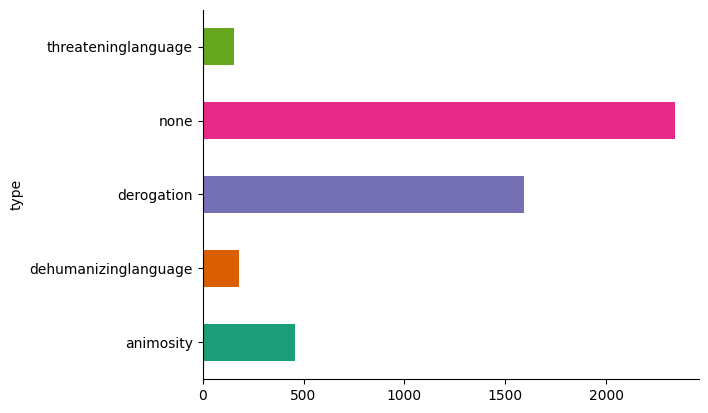

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
train_dataset.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from sklearn.utils import resample

# Function to balance a dataset by downsampling the majority class "none"
def balance_dataset(dataset, target_size):
    # Separate majority and minority classes
    df_majority = dataset[dataset.type == 'none']
    df_minority = dataset[dataset.type != 'none']

    # Downsample majority class
    df_majority_downsampled = resample(df_majority,
                                       replace=False,    # sample without replacement
                                       n_samples=target_size,  # to match the minority class size
                                       random_state=42)  # reproducible results

    # Combine minority class with downsampled majority class
    balanced_dataset = pd.concat([df_majority_downsampled, df_minority])

    return balanced_dataset

# Determine target size for downsampling based on the smallest minority class size in validation and test datasets
train_target_size = train_dataset[train_dataset.type != 'none'].type.value_counts().min()
val_target_size = val_dataset[val_dataset.type != 'none'].type.value_counts().min()
test_target_size = test_dataset[test_dataset.type != 'none'].type.value_counts().min()


# Balance validation and test datasets
train_balanced = balance_dataset(train_dataset, train_target_size)
val_balanced = balance_dataset(val_dataset, val_target_size)
test_balanced = balance_dataset(test_dataset, test_target_size)

# Display new class distribution for validation and test datasets
train_distribution = train_balanced['type'].value_counts()
val_distribution = val_balanced['type'].value_counts()
test_distribution = test_balanced['type'].value_counts()


In [ ]:
# Define the labels and category labels
labels = ["['asi.south', 'arab', 'mus']", "['bla']", "['none']", "['mus', 'asi.south']", "['blaman']", "['lgbtqa']", "['mus']", "['dis']", "['wom']", "['gayman']", "['asi.east.chin']", "['arab']", "['wom', 'blawom']", "['jew']", "['muswom']", "['blawom']", "['asi.east']", "['asi.south.pak']", "['immig']", "['gayman', 'gaywom']", "['trav']", "['gaywom']", "['mus', 'arab']", "['asi.south', 'asi.south.pak']", "['bla', 'asi.south']", "['trans']", "['asi.south']", "['mex']", "['mus', 'arab', 'asi.south']", "['mix.race', 'ethmin']", "['bla', 'mus']", "['nat.israel']", "['blawom', 'lgbtqa']", "['asiman']", "['mix.race']", "['bla', 'african']", "['ref']", "['asi.south', 'mus', 'arab']", "['immig', 'ref', 'asy']", "['asi.south', 'asiwom', 'mus']", "['sikh', 'mus']", "['blawom', 'muswom']", "['ind']", "['ethmin']", "['abo']", "['bis']", "['wc', 'trav']", "['nat.ireland']", "['jew', 'mus']", "['arab', 'immig']", "['asy']", "['asi.east.chin', 'bla', 'asi.south']", "['mus', 'jew']", "['asi.south', 'mus']", "['bla', 'ind']", "['muswom', 'sikhwom']", "['wc']", "['for']", "['blawom', 'mix.race']", "['hisp']", "['blawom', 'bla']", "['nat.france']", "['blawom', 'blaman']", "['african']", "['asi.south', 'arab']", "['gay']", "['trans', 'dis']", "['lgbtqa', 'bla']", "['indwom']", "['asi.south', 'asi', 'asi.south.pak']", "['arab', 'sikh', 'mus']", "['asiwom']", "['mus', 'blawom']", "['mus', 'sikh', 'arab']", "['mus', 'immig']", "['mus', 'bla']", "['asi']", "['trans', 'gay']", "['wom', 'ethmin']", "['asi.east', 'wom']", "['indig']", "['bla', 'ethmin']", "['immig', 'ethmin']", "['bla', 'mix.race']", "['arab', 'mus', 'asi.south']", "['immig', 'dis']", "['dis', 'ref']", "['bla', 'blawom']", "['hind']", "['sikh']", "['indigwom']", "['nat.wales']", "['nat.poland']", "['nat.germany']", "['nat.russia']", "['hisp', 'wom']", "['europe.east']", "['nat.southafrica']", "['african', 'bla']", "['asi.south.thai']", "['blawom', 'wom']", "['bla', 'asi']", "['mexwom']", "['dis', 'jew']", "['immig', 'ref']"]

category_labels = {
    'gender': {'gayman', 'gaywom', 'trans', 'wom', 'man', 'asiman', 'asiwom', 'blawom', 'blaman', 'indigwom', 'indwom', 'mexwom', 'muswom', 'sikhwom'},
    'race': {'abo', 'african', 'arab', 'asi', 'asy', 'asi.east', 'asi.south', 'blaman', 'blawom','bla', 'chin','ethmin', 'europe.east', 'ind', 'indig', 'lgbtqa', 'mex', 'mix.race', 'mus', 'nat.france', 'nat.germany','germany', 'nat.ireland', 'nat.israel', 'nat.poland', 'nat.russia', 'nat.southafrica', 'nat.wales', 'pak', 'sikh', 'sikhwom', 'thai','trav', 'wc', 'race', 'immig', 'russia', 'hisp', 'mix'},
    'disability': {'dis'},
    'religion': {'jew', 'hind', 'mus', 'sikh'},
    'sexual_orientation': {'gay', 'gayman', 'gaywom', 'lgbtqa', 'bis'},
    'national_origin': {'asi','asy', 'asi.east','east','nat', 'asi.south', 'asiman', 'asiwom', 'mex','germany', 'france', 'nat.france', 'nat.germany', 'nat.ireland','ireland', 'nat.israel', 'nat.poland','poland', 'nat.russia', 'nat.southafrica', 'nat.wales', 'pak', 'thai','trav', 'immig', 'russia', 'ref', 'hisp', 'southafrica', 'europe', 'wales', 'israel'},
    'none': {'none'}
}

# Add new columns to the datasets
def add_category_columns(df):
    df['gender'] = df['target'].apply(lambda x: any(item in x for item in category_labels['gender']))
    df['race'] = df['target'].apply(lambda x: any(item in x for item in category_labels['race']))
    df['disability'] = df['target'].apply(lambda x: any(item in x for item in category_labels['disability']))
    df['religion'] = df['target'].apply(lambda x: any(item in x for item in category_labels['religion']))
    df['sexual_orientation'] = df['target'].apply(lambda x: any(item in x for item in category_labels['sexual_orientation']))
    df['national_origin'] = df['target'].apply(lambda x: any(item in x for item in category_labels['national_origin']))
    df['none'] = df['target'].apply(lambda x: any(item in x for item in category_labels['none']))

    # Convert boolean values to integers (True = 1, False = 0)
    df['gender'] = df['gender'].astype(int)
    df['race'] = df['race'].astype(int)
    df['disability'] = df['disability'].astype(int)
    df['religion'] = df['religion'].astype(int)
    df['sexual_orientation'] = df['sexual_orientation'].astype(int)
    df['national_origin'] = df['national_origin'].astype(int)
    df['none'] = df['none'].astype(int)

# Apply the function to the balanced datasets
add_category_columns(train_balanced)
add_category_columns(val_balanced)
add_category_columns(test_balanced)



In [ ]:
# Drop the specified columns from the datasets
columns_to_drop = ['entry_id', 'target', 'split', 'type','label_gold', 'round.base', 'round.set', 'set', 'matched_text', 'matched_id']

train_balanced = train_balanced.drop(columns=columns_to_drop)
val_balanced = val_balanced.drop(columns=columns_to_drop)
test_balanced = test_balanced.drop(columns=columns_to_drop)

# Display the first few rows of the modified training dataset to verify the changes
train_balanced.head()

,text,gender,race,disability,religion,sexual_orientation,national_origin,none
3143,Bruce Lee would be so 🔥 if he wasn't asian..FA...,0,0,0,0,0,0,1
1397,bitches we gotta 🙏🏾 to god 😇,0,0,0,0,0,0,1
507,all it takes is one of those 🍙 to make us sick!,0,0,0,0,0,0,1
4566,there is two genders only 🚺🚹 said the 90s,0,0,0,0,0,0,1
3489,If I were Melania I would 🔝 myself,0,0,0,0,0,0,1


In [ ]:
# Extract category counts for each column except 'text' in the datasets
train_category_counts = train_balanced.drop(columns=['text']).sum()
val_category_counts = val_balanced.drop(columns=['text']).sum()
test_category_counts = test_balanced.drop(columns=['text']).sum()

# Combine all counts into a single DataFrame for easier comparison
category_counts = pd.DataFrame({
    'train': train_category_counts,
    'validation': val_category_counts,
    'test': test_category_counts
})

category_counts

,train,validation,test
gender,707,70,89
race,1525,169,190
disability,135,19,24
religion,467,46,56
sexual_orientation,348,41,55
national_origin,490,60,55
none,154,23,22


<ipython-input-77-10c4fd602ced>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(train_category_counts.index, rotation=45)
<ipython-input-77-10c4fd602ced>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(val_category_counts.index, rotation=45)
<ipython-input-77-10c4fd602ced>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(test_category_counts.index, rotation=45)


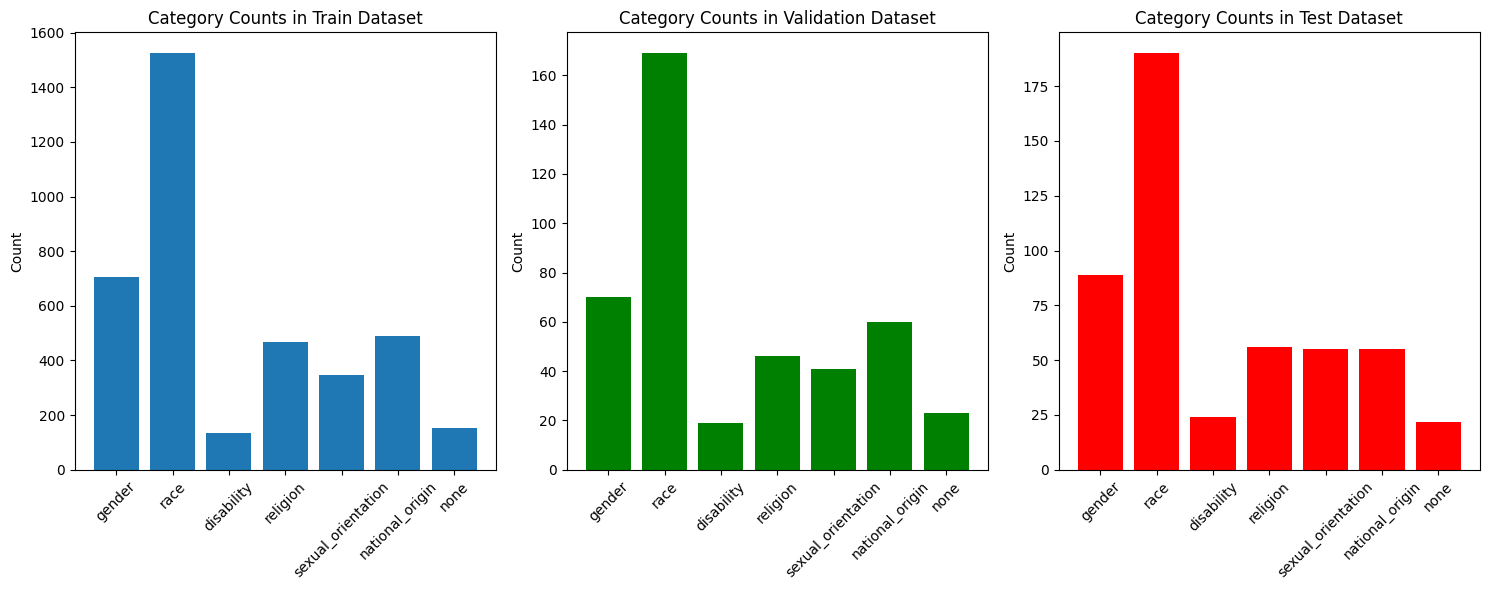

In [ ]:
import matplotlib.pyplot as plt

# Plot category counts for each dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Plot for train dataset
axes[0].bar(train_category_counts.index, train_category_counts)
axes[0].set_title('Category Counts in Train Dataset')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(train_category_counts.index, rotation=45)

# Plot for validation dataset
axes[1].bar(val_category_counts.index, val_category_counts, color='green')
axes[1].set_title('Category Counts in Validation Dataset')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(val_category_counts.index, rotation=45)

# Plot for test dataset
axes[2].bar(test_category_counts.index, test_category_counts, color='red')
axes[2].set_title('Category Counts in Test Dataset')
axes[2].set_ylabel('Count')
axes[2].set_xticklabels(test_category_counts.index, rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
def process_text_with_emojis(text):
    # Use emoji_list() function from the emoji library to extract emoji information
    emoji_info = emoji.emoji_list(text)
    offset = 0

    # Iterate over each emoji match
    for match in emoji_info:
        # Get the emoji and its start and end positions
        emoji_text = match['emoji']
        match_start = match['match_start']+ offset
        match_end = match['match_end']+ offset

        # Convert the emoji to text using emoji.demojize() and remove surrounding colons
        emoji_text_converted = emoji.demojize(emoji_text)[1:-1].replace('_', ' ')
        # Add whitespace if necessary
        if match_start > 0 and text[match_start - 1] != ' ':
            emoji_text_converted = ' ' + emoji_text_converted
        if match_end < len(text) and text[match_end] != ' ':
            emoji_text_converted += ' '

        offset += len(emoji_text_converted)-(match_end-match_start)

        # Replace the emoji in the original text with the converted text
        text = text[:match_start] + emoji_text_converted + text[match_end:]

    text = re.sub(r'\s+', ' ', text)

    return text

def replace_emoji_in_dataset(df, text_column):
    df[text_column] = df[text_column].apply(process_text_with_emojis)
    return df


In [ ]:
train_dataset_without_emoji = replace_emoji_in_dataset(train_balanced, "text")
val_dataset_without_emoji = replace_emoji_in_dataset(val_balanced, "text")
test_dataset_without_emoji = replace_emoji_in_dataset(test_balanced, "text")
train_dataset_without_emoji.head()

,text,gender,race,disability,religion,sexual_orientation,national_origin,none
3143,Bruce Lee would be so fire if he wasn't asian....,0,0,0,0,0,0,1
1397,bitches we gotta folded hands medium-dark skin...,0,0,0,0,0,0,1
507,all it takes is one of those rice ball to make...,0,0,0,0,0,0,1
4566,there is two genders only women’s room men’s r...,0,0,0,0,0,0,1
3489,If I were Melania I would TOP arrow myself,0,0,0,0,0,0,1


# MODEL

In [ ]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [ ]:
# Extract labels and texts
train_labels = train_dataset_without_emoji[['gender', 'race', 'disability', 'religion', 'sexual_orientation', 'national_origin', 'none']].values.tolist()
train_labels = np.array(train_labels, dtype=np.float32)
train_texts = train_dataset_without_emoji['text'].values

val_labels = val_dataset_without_emoji[['gender', 'race', 'disability', 'religion', 'sexual_orientation', 'national_origin', 'none']].values.tolist()
val_labels = np.array(val_labels, dtype=np.float32)
val_texts = val_dataset_without_emoji['text'].values

test_labels = test_dataset_without_emoji[['gender', 'race', 'disability', 'religion', 'sexual_orientation', 'national_origin', 'none']].values.tolist()
test_labels = np.array(test_labels, dtype=np.float32)
test_texts = test_dataset_without_emoji['text'].values

In [ ]:
from transformers import DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
class EmojiDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=315):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

In [ ]:
train_dataset = EmojiDataset(train_texts, train_labels, tokenizer)
val_dataset = EmojiDataset(val_texts, val_labels, tokenizer)
test_dataset = EmojiDataset(test_texts, val_labels, tokenizer)

In [ ]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch


def multi_labels_metrics(predictions, labels, threshold=0.3):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = labels

  f1 = f1_score(y_true, y_pred, average = 'macro')
  roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }

  return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = multi_labels_metrics(predictions=preds,
                                labels=p.label_ids)

  return result

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
# Convert train_labels to a PyTorch tensor
train_labels_tensor = torch.tensor(train_labels)

# Sum along the appropriate axis to get the count for each label
class_counts = torch.sum(train_labels_tensor, dim=0)

# Compute class weights based on the dataset
total_count = len(train_labels)
class_weights = total_count / class_counts
class_weights = class_weights / class_weights.sum()

# Convert class_weights to a list
class_weights = class_weights.tolist()
# Convert class weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [ ]:
from torch import nn
from transformers import DistilBertForSequenceClassification, DistilBertModel

# Define the custom model with class weights
class WeightedDistilBertForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, len(train_labels[0]))

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        cls_output = outputs[0][:, 0, :]  # Get the output of the [CLS] token
        logits = self.classifier(cls_output)

        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss(weight=class_weights.to(input_ids.device))  # Move weights to the same device
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

In [ ]:
# Instantiate the model and move it to the appropriate device
model = WeightedDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(train_labels[0]))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
path = F"/content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project/emoji_multilabel_classifier.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# Define a callback for early stopping
from transformers import EarlyStoppingCallback

# Training Arguments
args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir = './results',
    num_train_epochs=5,
    save_steps=100,
    warmup_steps=500,
    weight_decay=0.1,  # Increase weight decay
    save_total_limit=2,
    logging_steps=100,
    evaluation_strategy='steps',  # Evaluate every 10 steps
    save_strategy='steps',  # Save model every 10 steps
    load_best_model_at_end=True,
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  compute_metrics=compute_metrics,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])  # Stop training if no improvement after 3 evaluations)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#trainer.train()

Step,Training Loss,Validation Loss,Roc Auc,Hamming Loss,F1,Runtime,Samples Per Second,Steps Per Second
100,0.066700,0.048959,0.500603,0.201853,0.137482,2.610800,112.228000,7.278000
200,0.042400,0.036640,0.708638,0.164310,0.574727,2.798900,104.683000,6.788000
300,0.029800,0.027321,0.817073,0.092150,0.707322,2.926900,100.107000,6.492000
400,0.023300,0.023213,0.842227,0.081911,0.748134,2.946000,99.458000,6.450000
500,0.018600,0.025577,0.854566,0.072160,0.740717,2.861300,102.399000,6.640000
600,0.015800,0.022538,0.873624,0.072647,0.774992,2.949800,99.330000,6.441000
700,0.011900,0.023549,0.860401,0.069722,0.764236,2.876300,101.867000,6.606000


TrainOutput(global_step=795, training_loss=0.027432258623950885, metrics={'train_runtime': 390.5886, 'train_samples_per_second': 32.528, 'train_steps_per_second': 2.035, 'total_flos': 1035530735050350.0, 'train_loss': 0.027432258623950885, 'epoch': 5.0})

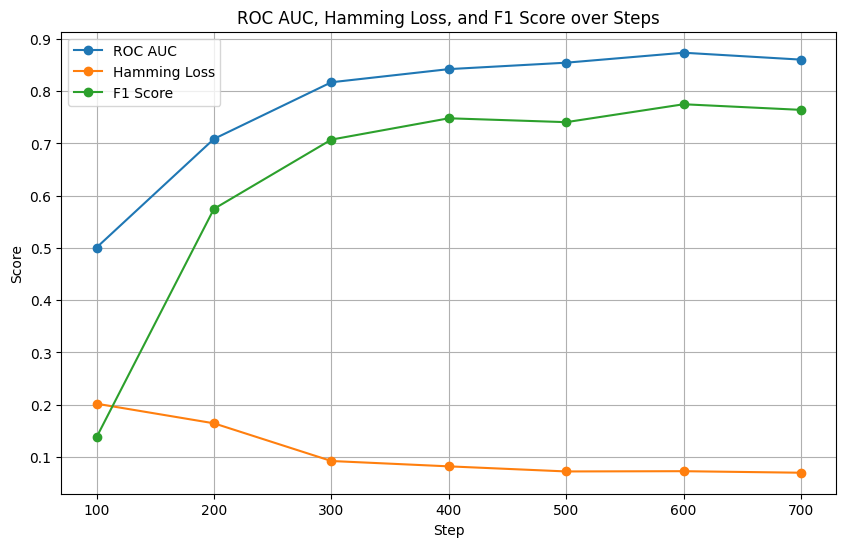

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data provided by the user
data = {
    "Step": [100, 200, 300, 400, 500, 600, 700],
    "Roc_Auc": [0.500603, 0.708638, 0.817073, 0.842227, 0.854566, 0.873624, 0.860401],
    "Hamming_Loss": [0.201853, 0.164310, 0.092150, 0.081911, 0.072160, 0.072647, 0.069722],
    "F1": [0.137482, 0.574727, 0.707322, 0.748134, 0.740717, 0.774992, 0.764236]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df["Step"], df["Roc_Auc"], label="ROC AUC", marker='o')
plt.plot(df["Step"], df["Hamming_Loss"], label="Hamming Loss", marker='o')
plt.plot(df["Step"], df["F1"], label="F1 Score", marker='o')

plt.xlabel("Step")
plt.ylabel("Score")
plt.title("ROC AUC, Hamming Loss, and F1 Score over Steps")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#trainer.evaluate()

{'eval_loss': 0.022537585347890854,
 'eval_roc_auc': 0.873624435504117,
 'eval_hamming_loss': 0.0726474890297416,
 'eval_f1': 0.7749924499297977,
 'eval_runtime': 2.8983,
 'eval_samples_per_second': 101.095,
 'eval_steps_per_second': 6.556,
 'epoch': 5.0}

In [ ]:
# # Save the model
# multilabel_model_save_name = 'emoji_multilabel_classifier.pt'
# multilabel_model_path = F"/content/drive/MyDrive/Colab Notebooks/Miniprojet/Deep_learning_project/{multilabel_model_save_name}"
# torch.save(model.state_dict(), multilabel_model_path) #model==multilabel model

# Predictions

In [ ]:
text = "Men stink as fuck"

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [ ]:
import torch
import numpy as np

# Assuming outputs is already defined and contains the logits
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs["logits"].cpu())

# Initialize preds based on the threshold condition
preds = np.zeros(probs.shape)
preds[np.where(probs >= 0.4)] = 1

if probs[0, -1] > 0.10:
    preds[0, -1] = 0

if probs[0, -1] < 0.10:
    preds[0, -1] = 1

# Print the results
print(probs)
print(preds)


tensor([[0.9645, 0.0945, 0.0040, 0.0158, 0.0473, 0.0146, 0.0665]],
       grad_fn=<SigmoidBackward0>)
[[1. 0. 0. 0. 0. 0. 1.]]
